In [1]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionDiffusionM1, ParcelsRandom
from operator import attrgetter

import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import math

In [2]:
#wind conditions
#0 --> 22.06.2018 03:00:00 2018, 6, 22, 3, 0, 0  14871600
#1 --> 22.05.2018 02:00:00 2018, 5, 22, 2, 0, 0 28857600
#2 --> 24.10.2018 07:00:00 2018, 10, 24, 7, 0, 0
#3 --> 14.02.2018 01:00:00 2018, 2, 14, 1, 0, 0
#4 --> 04.03.2018 12:00:00 2018, 3, 4, 3, 0, 0
#Extreme Wind (EW)--> 02.10.2018 19:00:00 2018,10, 2, 19, 0, 0

condition = '0'

In [7]:
dataset_folder = "/silod7/ramos/data_warnow_xaver/HRO20m_results/"
out_file = f"/silod7/ramos/warnow_winds/harbor90_2.zarr"

In [8]:
filenames = {
    "U": f"{dataset_folder}/HRO20m.surf.2018*.nc4",
    "V": f"{dataset_folder}/HRO20m.surf.2018*.nc4",
}

variables = {
    "U": "uu",
    "V": "vv",
}

dimensions = {}

dimensions['U'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}
dimensions['V'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}

variables['land']  = 'land'
dimensions['land'] = {'lon': 'xc', 'lat': 'yc','time': 'time'}
filenames['land']  = '/silod7/ramos/masks/landmask.xaver.nc'

variables['beach']  = 'beach'
dimensions['beach'] = {'lon': 'lon', 'lat': 'lat','time': 'time'}
filenames['beach']  = '/silod7/ramos/masks/warnow20m_beachmask_zero_OK.nc'

filenames['Kh_zonal']      = f"{dataset_folder}//HRO20m.surf.2018*.nc4"
filenames['Kh_meridional'] = f"{dataset_folder}//HRO20m.surf.2018*.nc4"

variables['Kh_zonal']      = 'AmC_3d'
variables['Kh_meridional'] = 'AmC_3d'

dimensions['Kh_zonal']      = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}
dimensions['Kh_meridional'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}

In [9]:
#kernel 

def AdvectionDiffusionM1_beach(particle, fieldset, time):

    dWx = ParcelsRandom.normalvariate(0, math.sqrt(math.fabs(particle.dt)))
    dWy = ParcelsRandom.normalvariate(0, math.sqrt(math.fabs(particle.dt)))

    Kxp1 = fieldset.Kh_zonal[time, particle.depth, particle.lat, particle.lon + fieldset.dres]
    Kxm1 = fieldset.Kh_zonal[time, particle.depth, particle.lat, particle.lon - fieldset.dres]
    dKdx = (Kxp1 - Kxm1) / (2 * fieldset.dres)

    u, v = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    bx = math.sqrt(2 * fieldset.Kh_zonal[time, particle.depth, particle.lat, particle.lon])

    Kyp1 = fieldset.Kh_meridional[time, particle.depth, particle.lat + fieldset.dres, particle.lon]
    Kym1 = fieldset.Kh_meridional[time, particle.depth, particle.lat - fieldset.dres, particle.lon]
    dKdy = (Kyp1 - Kym1) / (2 * fieldset.dres)

    by = math.sqrt(2 * fieldset.Kh_meridional[time, particle.depth, particle.lat, particle.lon])

    # Particle positions are updated only after evaluating all terms.
    lon_tmp = u * particle.dt + 0.5 * dKdx * (dWx**2 + particle.dt) + bx * dWx
    lat_tmp = v * particle.dt + 0.5 * dKdy * (dWy**2 + particle.dt) + by * dWy

    #stress  = fieldset.taubmax[time,particle.depth,particle.lat,particle.lon]
    landing = fieldset.land[time,particle.depth,particle.lat+lat_tmp,particle.lon+lon_tmp]
    particle.land = landing
    #if stress >= fieldset.tau_crit:
    if landing < 0.4:
      if particle.stop == 0.0:
        particle.lon += lon_tmp
        particle.lat += lat_tmp

        beachfield = fieldset.beach[time,particle.depth,particle.lat, particle.lon]

        if beachfield < 0.3:
           particle.stop = 1.0

In [10]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,
                                mesh='flat',
                                interp_method={'U': 'freeslip', 'V': 'freeslip','Kh_zonal':'linear',
                                               'Kh_meridional':'linear','land':'linear','beach':'linear'}, allow_time_extrapolation=True)
 
fieldset.add_constant('dres', 10)

In [11]:
class SampleParticle(JITParticle):
    land = Variable('land', initial=0.0)
    beach = Variable('beach', initial=0.0)
    stop = Variable('stop', initial=0.0)
    distance = Variable("distance", initial=0.0, dtype=np.float32)
    prev_lon = Variable("prev_lon", dtype=np.float32, to_write=False, initial=attrgetter("lon"))
    prev_lat = Variable("prev_lat", dtype=np.float32, to_write=False, initial=attrgetter("lat"))

In [12]:
pset = ParticleSet.from_line(
    fieldset=fieldset, 
    pclass=SampleParticle, 
    start=(704440, 5998425),  # releasing on a line: the start longitude and latitude
    finish=(704760, 5998425), # releasing on a line: the end longitude and latitude
    size=1000,
    time=14871600,
)

In [ ]:


pset = ParticleSet.from_list(
    fieldset=fieldset, 
    pclass=SampleParticle, 
    lon=parts_lon, 
    lat=parts_lat, 
    time=start)

In [13]:
def TotalDistance(particle, fieldset, time):
    """Calculate total Euclidean distance traveled in meters in UTM (flat) coordinates"""
    dx = particle.lon - particle.prev_lon
    dy = particle.lat - particle.prev_lat

    particle.distance += math.sqrt(dx**2 + dy**2)

    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

In [14]:
output_file = pset.ParticleFile(name=out_file, outputdt=timedelta(hours=1))
ParcelsRandom.seed(1636)

INFO: Compiled ParcelsRandom ==> /tmp/parcels-3454/parcels_random_323a7ec7-0113-4813-8820-167cca114a6f.c


In [15]:
def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

In [16]:
pset.execute([AdvectionDiffusionM1_beach, TotalDistance], 
             runtime=timedelta(days=30), 
             dt=timedelta(minutes=30),
             output_file=output_file)

INFO: Output files are stored in /silod7/ramos/warnow_winds/harbor90_2.zarr.
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2592000.0/2592000.0 [05:08<00:00, 8413.82it/s]


# QUICK VIEW

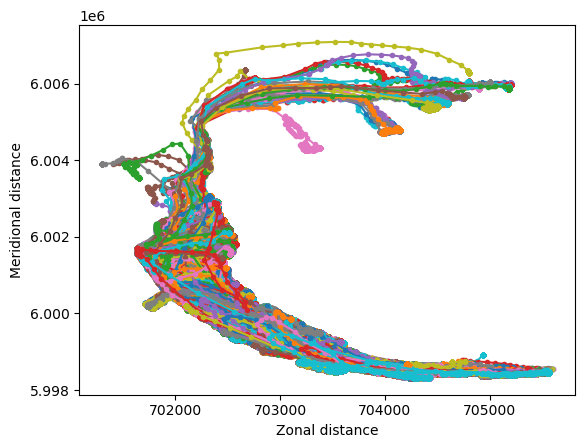

In [17]:
import matplotlib.pyplot as plt

ds = xr.open_zarr("/silod7/ramos/warnow_winds/harbor90_2.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance")
plt.ylabel("Meridional distance")
plt.show()

In [18]:
#Convert the file
ds_from_zarr = xr.open_zarr('/silod7/ramos/warnow_winds/harbor90_2.zarr')
ds_from_zarr.to_netcdf('/silod7/ramos/warnow_winds/harbor90_2.nc')

In [41]:
#debugging
import xarray as xr

# Load your dataset
ds = xr.open_dataset('/silod7/ramos/warnow_winds/harbor90.nc')

# Inspect the data for NaN or inf values
print(ds.isnull().sum())  # Count of NaN values
print(np.isinf(ds).sum())  # Count of inf values

<xarray.Dataset> Size: 64B
Dimensions:   ()
Data variables:
    beach     int64 8B 16056
    distance  int64 8B 16056
    land      int64 8B 16056
    lat       int64 8B 16056
    lon       int64 8B 16056
    stop      int64 8B 16056
    time      int64 8B 16056
    z         int64 8B 16056
<xarray.Dataset> Size: 64B
Dimensions:   ()
Data variables:
    beach     int64 8B 0
    distance  int64 8B 0
    land      int64 8B 0
    lat       int64 8B 0
    lon       int64 8B 0
    stop      int64 8B 0
    time      int64 8B 0
    z         int64 8B 0


In [19]:
print([p.distance for p in pset])

[6212.1646, 19586.488, 7011.45, 13447.994, 15694.419, 12783.513, 7245.017, 6784.674, 1295.558, 9807.253, 16976.193, 11816.056, 15947.574, 6661.9956, 11558.99, 14361.48, 19540.982, 12055.864, 9612.248, 6097.6167, 12508.9795, 12332.506, 6462.2188, 6833.8843, 13450.145, 7527.4917, 12292.698, 4412.8467, 10045.118, 8724.718, 16905.48, 7373.24, 5999.3926, 1354.3269, 1127.1398, 4504.3237, 13405.288, 17704.555, 15198.216, 6133.247, 12611.734, 13577.286, 8548.464, 5435.942, 5350.884, 5324.73, 6774.7363, 17977.43, 6601.984, 14390.493, 14921.852, 13382.354, 27176.004, 13312.275, 5996.4077, 7144.8154, 6673.388, 3761.6729, 8825.685, 1250.5532, 14126.6, 13105.004, 14559.441, 6801.1123, 13222.457, 12672.132, 1385.5596, 13996.025, 28257.95, 14941.767, 6540.8716, 16742.215, 9424.713, 15130.548, 12798.086, 13699.584, 6282.0205, 9083.127, 6991.596, 4469.225, 11746.722, 1275.7358, 19014.102, 16104.583, 10946.34, 7162.171, 7506.6865, 10106.95, 15792.691, 10807.363, 8077.6, 11369.033, 8816.494, 17537.604, 6

In [21]:
distances = [p.distance for p in pset]

In [22]:
# Calculate statistics
mean_distance = sum(distances) / len(distances) if distances else 0
max_distance = max(distances) if distances else None
min_distance = min(distances) if distances else None

# Print the results
print("Mean:", mean_distance)
print("Max:", max_distance)
print("Min:", min_distance)

Mean: 9873.524040039063
Max: 30800.29
Min: 1127.1398
